In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [10]:
# Reading the dataset
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [11]:
# Data exploration
print(df.head())
print(df.shape)
print(df.columns)
print(df.info())
print(df.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [12]:
# Checking for missing values and duplicates
print(df.isnull().sum())
print("Number of duplicates: ", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.shape)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Number of duplicates:  1081
(283726, 31)


In [13]:
# Class distribution
print(df['Class'].unique())
print(df['Class'].value_counts())

[0 1]
Class
0    283253
1       473
Name: count, dtype: int64


In [14]:
# Percentage of fraud and normal transactions
fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0]
normal_percentage = len(normal) / (len(fraud) + len(normal))
fraud_percentage = len(fraud) / (len(fraud) + len(normal))
print('Percentage of fraud transactions = ', round(fraud_percentage * 100, 3))
print('Percentage of normal transactions = ', round(normal_percentage * 100, 3))

Percentage of fraud transactions =  0.167
Percentage of normal transactions =  99.833


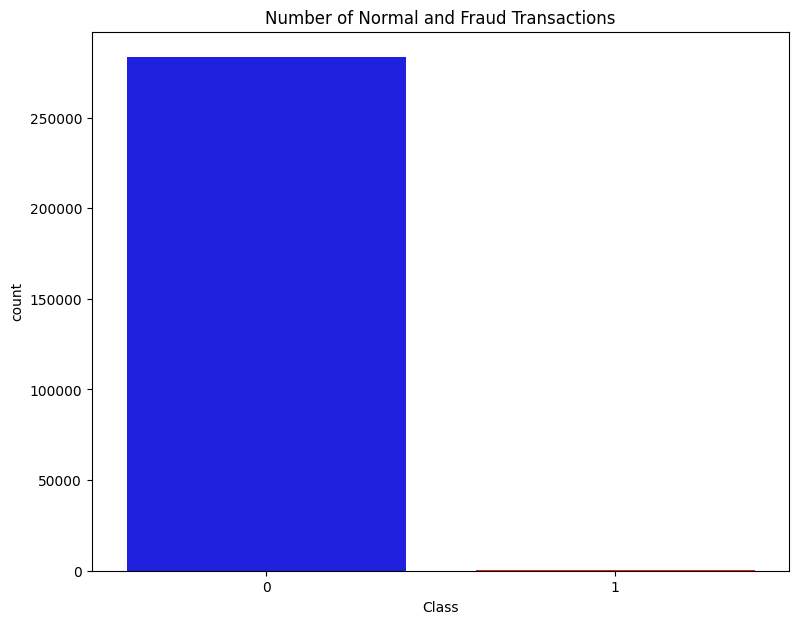

In [15]:
# Data Visualization
plt.figure(figsize=(9, 7))
sns.countplot(data=df, x='Class', palette=['blue', 'red'])
plt.title("Number of Normal and Fraud Transactions")
plt.show()

<Figure size 800x600 with 0 Axes>

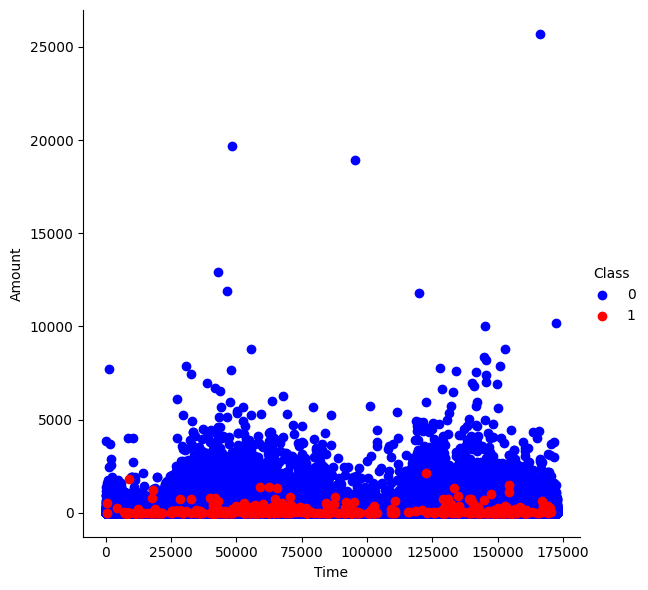

In [16]:
plt.figure(figsize=(8, 6))
sns.FacetGrid(df, hue="Class", height=6, palette=['blue', 'red']).map(plt.scatter, "Time", "Amount").add_legend()
plt.show()

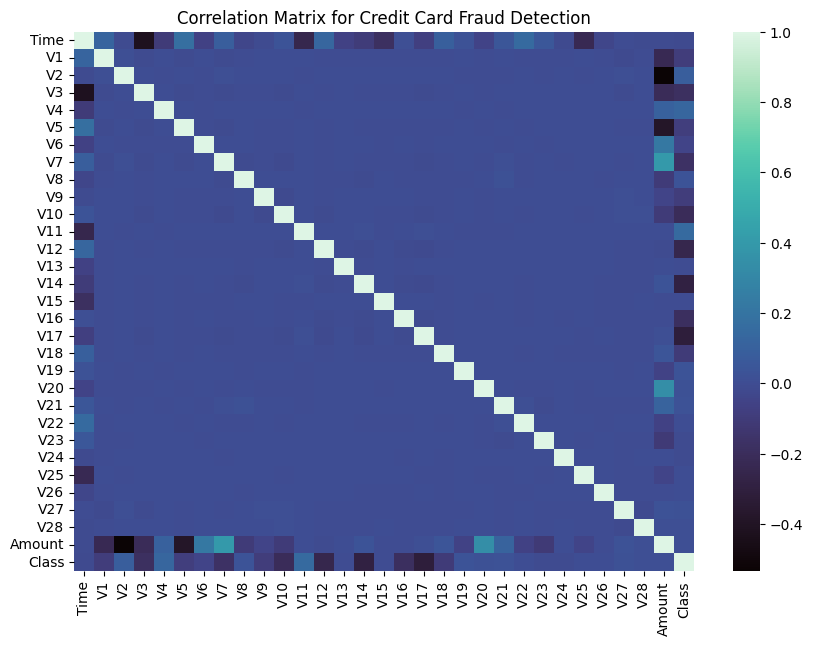

In [17]:
plt.figure(figsize=(10, 7))
sns.heatmap(data=df.corr(), cmap='mako')
plt.title("Correlation Matrix for Credit Card Fraud Detection")
plt.show()

In [18]:
# Feature selection
corr_mat = df.corr(method='pearson')
h_feature = corr_mat.index[abs(corr_mat['Class']) >= 0.1].tolist()
h_feature.remove('Class')
print("High correlation features: ", h_feature)

High correlation features:  ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']


In [19]:
# Splitting the data
X = df[h_feature]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


In [20]:
# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Model training and evaluation function
def model_train_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print('Accuracy = {}'.format(accuracy_score(y_test, prediction)))
    print(classification_report(y_test, prediction))
    matrix = confusion_matrix(y_test, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    plt.show()

Accuracy = 0.9991071218778637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.85      0.56      0.68       142

    accuracy                           1.00     85118
   macro avg       0.93      0.78      0.84     85118
weighted avg       1.00      1.00      1.00     85118



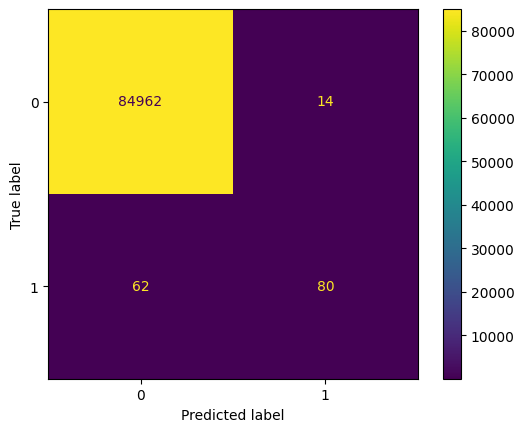

In [22]:
# Logistic Regression
logistic = LogisticRegression(max_iter=10000)
model_train_test(logistic, X_train, y_train, X_test, y_test)


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# Calculate accuracy for testing data
y_test_pred_rf = rf_model.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Random Forest Testing Accuracy: {test_accuracy_rf}")

Random Forest Testing Accuracy: 0.9995065673535563


In [28]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Define steps in the pipeline
smote = SMOTE(random_state=42)
under = RandomUnderSampler(random_state=42)
model = LogisticRegression(max_iter=10000)
steps = [('over', smote), ('under', under), ('model', model)]

# Create pipeline
pipeline = Pipeline(steps=steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate performance
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.05068937550689376
Recall: 0.8802816901408451
F1-score: 0.09585889570552147
